# Look at UMAP embeddings in the trained models

Required python imports:
```python
graph2tac  # this project
pandas
jupyter
altair  # plot library
vega_datasets  # for altair settings
vegafusion-python-embed
altair_transform
pynndescent==0.5.8  # need 0.5.8 to prevent issue with umap-learn
umap-learn
```

In [1]:
import tensorflow as tf
from pathlib import Path
import pandas as pd
from typing import Optional

import pynndescent  # needs to be version 0.5.8 else get error ValueError: cannot assign slice from input of different size
import umap  # use the umap-learn package and not umap pip package
import altair as alt

from graph2tac.tfgnn.predict import TFGNNPredict

import vegafusion as vf
vf.enable(
    mimetype="png",  # use "png" to make plots show offline in notebook (but they will be blurry for reasons I don't understand)
    embed_options={"scaleFactor": 4},  # scaleFactor 4 makes exported png look good
    row_limit=None
)

2023-11-21 11:27:11.952900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


vegafusion.enable(mimetype='png', row_limit=None, embed_options={'scaleFactor': 4})

In [2]:
# test data path
TEST_MODEL_PATH = Path("../tests/data/mini_stdlib/params/load_previous_model/model")
TEST_DATASET_PATH = Path("../tests/data/mini_stdlib/dataset/")

# trained g2t models
MODELS_PATH = Path.home() / "g2t-models"  # SET TO CORRECT LOCATION
assert MODELS_PATH.is_dir(), f"{MODELS_PATH} is not a directory.  Set to correct location."
G2T_ANON_PATH = MODELS_PATH / "g2t_anon_update"
G2T_NODEF_PATH = MODELS_PATH / "g2t_nodef_frozen"
G2T_NAMED_PATH = MODELS_PATH / "g2t_named"

# the dataset used to train the g2t models
DATASET_PATH = Path.home() / "g2t-datasets"  # SET TO CORRECT LOCATION
assert DATASET_PATH.is_dir(), f"{DATASET_PATH} is not a directory.  Set to correct location."
G2T_DATASET_PATH = DATASET_PATH / Path("v15-opam-coq8.11-partial/dataset/")

In [3]:
# altair plots need special techniques to handle more than 5000 datapoints
# (since data is stored inside the plot by default)

# pick one:

#alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')  # stores plot data in json files locally

DataTransformerRegistry.enable('json')

In [4]:
def get_umap_data(model_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    print(f"Loading model {model_path}...\n")
    model = TFGNNPredict(
        log_dir=model_path,
        allocation_reserve=0.0,  # don't expand the definition embeddings table
        tactic_expand_bound=1,   # dummy value
        search_expand_bound=1,   # dummy value
    )
    
    print(f"\nExtracting data from the model...\n")
    num_of_base_node_labels = model.graph_constants.base_node_label_num
    num_of_node_labels = model.graph_constants.node_label_num
    print(f"There are {num_of_node_labels} labels.")
    print(f"The first {num_of_base_node_labels} are non-definition node labels which we will skip.")
    print(f"The remaining {num_of_node_labels - num_of_base_node_labels} are definition labels.")
    
    # this contains extra buffer so we can grow the embedding dictionary
    # we must remove those buffer embeddings
    definition_embeddings = model.prediction_task.graph_embedding._node_embedding.embeddings
    assert tf.shape(definition_embeddings)[0] == num_of_node_labels, (tf.shape(definition_embeddings)[0], num_of_node_labels)
    definition_embeddings = definition_embeddings[num_of_base_node_labels:num_of_node_labels]

    definition_names = model.graph_constants.label_to_names
    assert tf.shape(definition_names)[0] == num_of_node_labels, (tf.shape(definition_names)[0], num_of_node_labels)
    definition_names = definition_names[num_of_base_node_labels:num_of_node_labels]

    definition_ids = model.graph_constants.label_to_ident
    assert tf.shape(definition_ids)[0] == num_of_node_labels, (tf.shape(definition_ids)[0], num_of_node_labels)
    definition_ids = definition_ids[num_of_base_node_labels:num_of_node_labels]
    
    print("\nCalculating umap embeddings... (This may take a number of minutes.)")
    reducer = umap.UMAP(
        init="pca",  # the default initializer doesn't like our data, possibly because of too many near duplicates
        random_state=0,  # for reproducibility
        metric="euclidean",  # cosine would be better, but it has issues with our data
        verbose=True
    )
    definition_embds_umap = reducer.fit_transform(definition_embeddings)
    definition_embds_umap = definition_embds_umap.astype("float16")  # to reduce data

    print("Compile data into a dataframe.")
    def_embds_umap_df = pd.DataFrame(definition_embds_umap, columns=["embd_umap_x", "embd_umap_y"])

    def_embds_meta_df = pd.DataFrame({"name": definition_names, "id": definition_ids})

    return def_embds_umap_df, def_embds_meta_df

In [5]:
test_umap_df, test_meta_df = get_umap_data(TEST_MODEL_PATH)
test_umap_df, test_meta_df

Loading model ../tests/data/mini_stdlib/params/load_previous_model/model...

graph2tac:INFO - loading json graph_constants file


2023-11-21 11:27:22.723567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 11:27:22.725674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 11:27:22.727148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #10
graph2tac:INFO - restored checkpoint #10!


2023-11-21 11:27:23.323101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 11:27:23.324816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 11:27:23.326487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

tensorflow:WARNING - Mapping types may not work well with tf.nest. Prefer using MutableMapping for <class 'tensorflow_gnn.graph.graph_tensor._ImmutableMapping'>
tensorflow:WARNING - Mapping types may not work well with tf.nest. Prefer using MutableMapping for <class 'tensorflow_gnn.graph.graph_tensor._ImmutableMapping'>
tensorflow:WARNING - Mapping types may not work well with tf.nest. Prefer using MutableMapping for <class 'tensorflow_gnn.graph.graph_tensor._ImmutableMapping'>


2023-11-21 11:27:26.984563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:27:26.984658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:27:27.075414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tf.math.add/cond/zeros/Reshape/tf.math.add/sub' with dtype in


Extracting data from the model...

There are 1028 labels.
The first 26 are non-definition node labels which we will skip.
The remaining 1002 are definition labels.

Calculating umap embeddings... (This may take a number of minutes.)
UMAP(init='pca', random_state=0, verbose=True)
Tue Nov 21 11:27:40 2023 Construct fuzzy simplicial set


/Users/jasonrute/Development/ihes_atp/graph2tac/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Nov 21 11:27:41 2023 Finding Nearest Neighbors
Tue Nov 21 11:27:43 2023 Finished Nearest Neighbor Search
Tue Nov 21 11:27:46 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Nov 21 11:27:49 2023 Finished embedding
Compile data into a dataframe.


(      embd_umap_x  embd_umap_y
 0        8.343750    -2.210938
 1        7.148438     0.937500
 2        5.046875    -3.314453
 3        5.980469    -0.608398
 4        8.789062     0.200439
 ...           ...          ...
 997      5.062500    -3.468750
 998      2.996094    -1.632812
 999      4.789062     0.511719
 1000     6.753906     0.817871
 1001     6.398438    -2.785156
 
 [1002 rows x 2 columns],
                                name                   id
 0               Coq.Init.Logic.True  4733428306111738697
 1                  Coq.Init.Logic.I  -706415803758670049
 2          Coq.Init.Logic.True_rect -7512869496412662968
 3          Coq.Init.Logic.True_sind -8661462126360313404
 4           Coq.Init.Logic.True_ind  5040793429407251846
 ...                             ...                  ...
 997           Coq.Init.Byte.of_bits     7238516932848996
 998           Coq.Init.Byte.to_bits  -889142169426662953
 999   Coq.Init.Byte.of_bits_to_bits  5683082132668187680
 1000  C

In [11]:
g2t_anon_umap_df, g2t_meta_df = get_umap_data(G2T_ANON_PATH)
# uncomment to only use 1/10 of data
#g2t_anon_umap_df = g2t_anon_umap_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
#g2t_meta_df = g2t_meta_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
g2t_anon_umap_df, g2t_meta_df

Loading model /Users/jasonrute/g2t-models/g2t_anon_update...

graph2tac:INFO - loading json graph_constants file
graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #247
graph2tac:INFO - restored checkpoint #247!


2023-11-21 11:28:56.262903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:28:56.262998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:28:56.345010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tf.math.add_1/cond/zeros/Reshape/tf.math.add_1/sub' with dtyp


Extracting data from the model...

There are 459005 labels.
The first 26 are non-definition node labels which we will skip.
The remaining 458979 are definition labels.

Calculating umap embeddings... (This may take a number of minutes.)
UMAP(init='pca', random_state=0, verbose=True)
Tue Nov 21 11:29:08 2023 Construct fuzzy simplicial set


/Users/jasonrute/Development/ihes_atp/graph2tac/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Nov 21 11:29:08 2023 Finding Nearest Neighbors
Tue Nov 21 11:29:08 2023 Building RP forest with 39 trees
Tue Nov 21 11:29:14 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Tue Nov 21 11:29:40 2023 Finished Nearest Neighbor Search
Tue Nov 21 11:29:42 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 21 11:35:31 2023 Finished embedding
Compile data into a dataframe.


(        embd_umap_x  embd_umap_y
 0          6.726562    12.765625
 1          6.003906    13.695312
 2         -2.945312    14.171875
 3         -2.710938    14.507812
 4         -2.990234    14.085938
 ...             ...          ...
 458974     0.049194    -0.602051
 458975    -2.730469    -0.196899
 458976    -1.732422    -1.597656
 458977     6.300781    -4.898438
 458978     6.265625    -4.925781
 
 [458979 rows x 2 columns],
                                                 name                   id
 0                                Coq.Init.Logic.True  4733428306111738697
 1                                   Coq.Init.Logic.I  -706415803758670049
 2                           Coq.Init.Logic.True_rect -7512869496412662968
 3                           Coq.Init.Logic.True_sind -8661462126360313404
 4                            Coq.Init.Logic.True_ind  5040793429407251846
 ...                                              ...                  ...
 458974                              

In [12]:
g2t_nodef_umap_df, g2t_meta_df = get_umap_data(G2T_NODEF_PATH)
# uncomment to only use 1/10 of data
# g2t_nodef_umap_df = g2t_nodef_umap_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
# g2t_meta_df = g2t_meta_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
g2t_nodef_umap_df, g2t_meta_df

Loading model /Users/jasonrute/g2t-models/g2t_nodef_frozen...

graph2tac:INFO - loading json graph_constants file
graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #389
graph2tac:INFO - restored checkpoint #389!


2023-11-21 11:35:37.728560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:35:37.728658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:35:37.804353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tf.math.add_2/cond/zeros/Reshape/tf.math.add_2/sub' with dtyp


Extracting data from the model...

There are 459005 labels.
The first 26 are non-definition node labels which we will skip.
The remaining 458979 are definition labels.

Calculating umap embeddings... (This may take a number of minutes.)
UMAP(init='pca', random_state=0, verbose=True)
Tue Nov 21 11:35:49 2023 Construct fuzzy simplicial set


/Users/jasonrute/Development/ihes_atp/graph2tac/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Nov 21 11:35:49 2023 Finding Nearest Neighbors
Tue Nov 21 11:35:49 2023 Building RP forest with 39 trees
Tue Nov 21 11:35:55 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	 8  /  19
	Stopping threshold met -- exiting after 8 iterations
Tue Nov 21 11:36:12 2023 Finished Nearest Neighbor Search
Tue Nov 21 11:36:14 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 21 11:43:47 2023 Finished embedding
Compile data into a dataframe.


(        embd_umap_x  embd_umap_y
 0          9.062500     9.351562
 1          6.480469     2.931641
 2          6.371094     2.798828
 3          1.510742     4.785156
 4          3.300781     3.595703
 ...             ...          ...
 458974    10.515625     1.255859
 458975    10.125000    -1.229492
 458976    11.554688    18.984375
 458977    16.890625    12.148438
 458978    23.687500     7.652344
 
 [458979 rows x 2 columns],
                                                 name                   id
 0                                Coq.Init.Logic.True  4733428306111738697
 1                                   Coq.Init.Logic.I  -706415803758670049
 2                           Coq.Init.Logic.True_rect -7512869496412662968
 3                           Coq.Init.Logic.True_sind -8661462126360313404
 4                            Coq.Init.Logic.True_ind  5040793429407251846
 ...                                              ...                  ...
 458974                              

In [13]:
g2t_named_umap_df, g2t_meta_df = get_umap_data(G2T_NAMED_PATH)
# uncomment to only use 1/10 of data
# g2t_named_umap_df = g2t_named_umap_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
# g2t_meta_df = g2t_meta_df[g2t_meta_df["id"].astype(str).str[-1] == '0']
g2t_named_umap_df, g2t_meta_df

Loading model /Users/jasonrute/g2t-models/g2t_named...

graph2tac:INFO - loading json graph_constants file


2023-11-21 11:43:51.775251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 11:43:51.776747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 11:43:51.778504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

graph2tac:INFO - no checkpoint number specified, using latest available checkpoint #232


2023-11-21 11:43:52.074005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 11:43:52.075781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 11:43:52.077239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

graph2tac:INFO - restored checkpoint #232!


2023-11-21 11:43:53.967583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:43:53.967680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?]
	 [[{{node Placeholder_1}}]]
2023-11-21 11:43:54.054612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tf.math.add_3/cond/zeros/Reshape/tf.math.add_3/sub' with dtyp


Extracting data from the model...

There are 459005 labels.
The first 26 are non-definition node labels which we will skip.
The remaining 458979 are definition labels.

Calculating umap embeddings... (This may take a number of minutes.)
UMAP(init='pca', random_state=0, verbose=True)
Tue Nov 21 11:44:04 2023 Construct fuzzy simplicial set


/Users/jasonrute/Development/ihes_atp/graph2tac/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Nov 21 11:44:05 2023 Finding Nearest Neighbors
Tue Nov 21 11:44:05 2023 Building RP forest with 39 trees
Tue Nov 21 11:44:12 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Tue Nov 21 11:44:23 2023 Finished Nearest Neighbor Search
Tue Nov 21 11:44:25 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 21 11:49:39 2023 Finished embedding
Compile data into a dataframe.


(        embd_umap_x  embd_umap_y
 0         12.046875     0.675293
 1         11.156250    10.375000
 2         14.898438     2.658203
 3         14.921875     7.289062
 4         14.929688     7.347656
 ...             ...          ...
 458974     4.371094    11.109375
 458975    -0.429443    -3.324219
 458976    -1.403320    -1.722656
 458977     0.503418    -3.769531
 458978    -0.442383    -2.974609
 
 [458979 rows x 2 columns],
                                                 name                   id
 0                                Coq.Init.Logic.True  4733428306111738697
 1                                   Coq.Init.Logic.I  -706415803758670049
 2                           Coq.Init.Logic.True_rect -7512869496412662968
 3                           Coq.Init.Logic.True_sind -8661462126360313404
 4                            Coq.Init.Logic.True_ind  5040793429407251846
 ...                                              ...                  ...
 458974                              

In [14]:
g2t_umap_dfs = {"G2T-NoDef": g2t_nodef_umap_df, "G2T-Anon": g2t_anon_umap_df, "G2T-Named": g2t_named_umap_df}

In [18]:
def plot_umap3(umap_dfs: dict[str, pd.DataFrame], color: dict["str", pd.Series] = None, tooltip: pd.DataFrame = None, opacity=0.01, size=2, sample: float=None):
    dfs_ = []
    if sample is not None:
        umap_dfs = {k:df.sample(frac=sample, random_state=0) for k,df in umap_dfs.items()}
        if color:
            color = {k:s.sample(frac=sample, random_state=0) for k,s in color.items()}
        if tooltip is not None:
            tooltip = tooltip.sample(frac=sample, random_state=0)
        #raise NotImplemented()
    if color:
        assert len(color) == 1
        color_key = list(color.keys())[0]
    for model, df_ in umap_dfs.items():
        df_ = df_.copy()
        df_["model"] = model
        if color:
            df_[color_key] = color[color_key]
        if tooltip is not None:
            for col in tooltip.columns:
                df_[col] = tooltip[col]
        dfs_.append(df_)
    df = pd.concat(dfs_)
    chart = alt.Chart(df).mark_circle(size=size, opacity=opacity).encode(
        alt.X("embd_umap_x:Q").axis(None).scale(zero=False),
        alt.Y("embd_umap_y:Q").axis(None).scale(zero=False),
        alt.Column("model:N").title(None).header(labelFontWeight="bold", labelFontSize=12),
    ).resolve_scale(
        x="independent",
        y="independent",
    ).configure_view(
        strokeWidth=0
    )
    if tooltip is not None:
        chart = chart.encode(
            alt.Tooltip([col + ":N" for col in tooltip.columns])
        )
    if color:
        chart = chart.encode(
            alt.Color(color_key + ":N").legend(symbolOpacity=1).title(None)
        )
    return chart

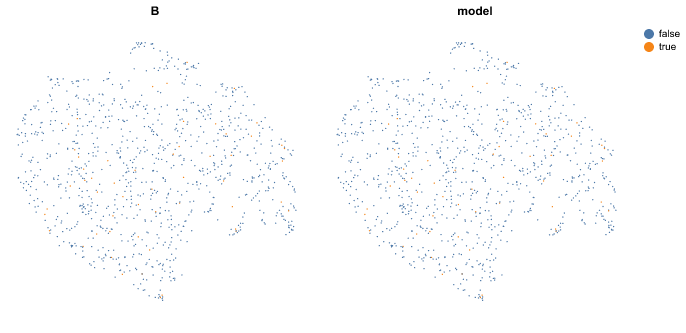

In [16]:
chart = plot_umap3({"model": test_umap_df, "B": test_umap_df}, opacity=1, color = {"mycolor": test_meta_df["name"].str.endswith("r")}, tooltip=test_meta_df)
#chart.save("umap_test.png", scale_factor=4)
chart

## Plot with no color

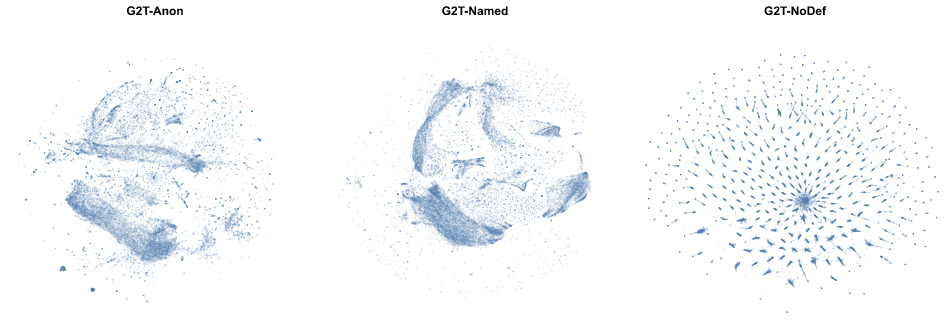

In [23]:
chart = plot_umap3(
    g2t_umap_dfs,
    opacity=.1,
    sample=0.1
)
#chart.save("umap_g2t_no_color.png", scale_factor=4)
chart

## Color by mathcomp category

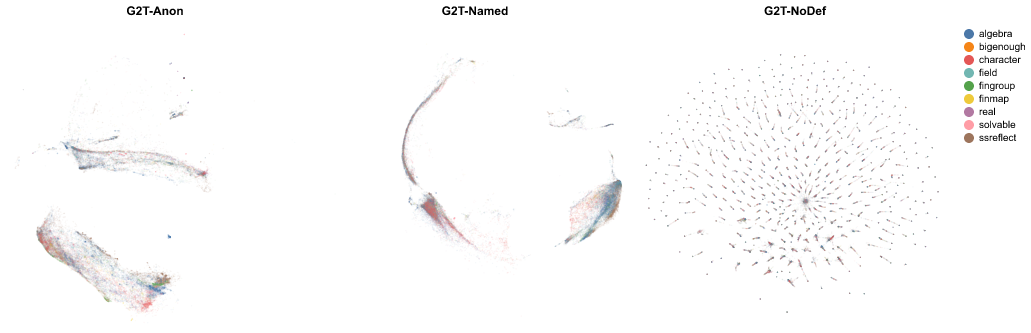

In [24]:
def make_chart():
    mask = g2t_meta_df["name"].str.startswith("mathcomp.")
    meta_df = g2t_meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in g2t_umap_dfs.items()}
    color = {"mathcomp category": meta_df["name"].str.extract(r"mathcomp\.([a-zA-Z0-9]*)\.*")[0]}
    return plot_umap3(umap_dfs, color=color, opacity=0.05)
chart = make_chart()
chart.save("umap_g2t_mathcomp_by_category.png", scale_factor=4)
chart

## Color by top five first-level in fully qualified name

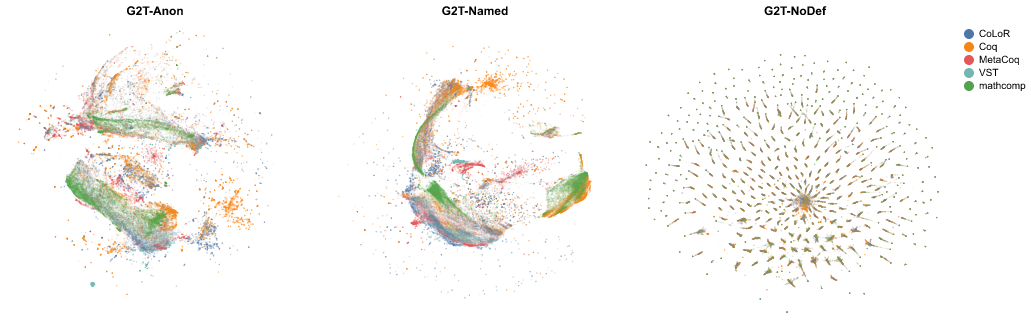

In [26]:
def make_chart():
    umap_dfs = {k: df.copy() for k, df in g2t_umap_dfs.items()}
    meta_df = g2t_meta_df.copy()

    mask = meta_df["name"].str.contains(".")
    meta_df = meta_df[mask].copy()
    umap_dfs = {k: df[mask].copy() for k, df in umap_dfs.items()}

    meta_df["first_name"] = meta_df["name"].str.extract(r"([a-zA-Z0-9]*)\.*")
    top_names = meta_df["first_name"].value_counts()
    
    mask = meta_df["first_name"].isin(top_names.index[:5])
    meta_df = meta_df[mask].copy()
    umap_dfs = {k: df[mask].copy() for k, df in umap_dfs.items()}

    color = {"first_name": meta_df["first_name"]}
    return plot_umap3(umap_dfs, color=color, opacity=0.1, sample=.5)
chart = make_chart()
chart.save("umap_g2t_top5_by_name.png", scale_factor=4)
chart

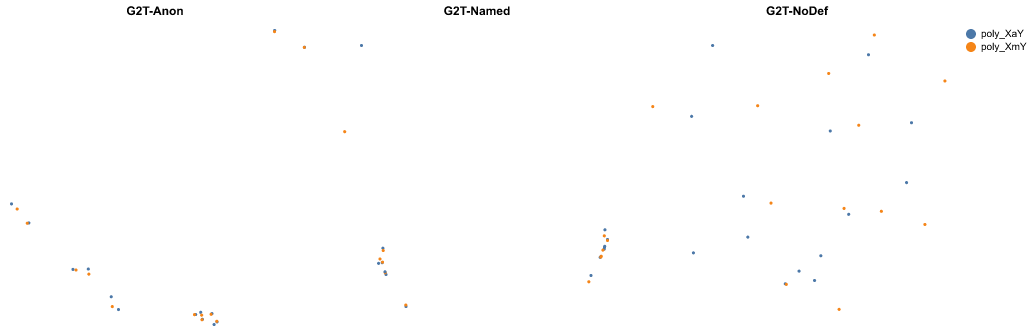

In [28]:
def make_chart():
    meta_df = g2t_meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in g2t_umap_dfs.items()}
    
    mask = g2t_meta_df["name"].str.startswith("mathcomp.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.match(r".*poly_X.Y.*")
    meta_df = meta_df[mask].copy()
    umap_dfs = {k: df[mask].copy() for k, df in umap_dfs.items()}
    
    color = {"x": meta_df["name"].str.extract(r".*(poly_X.Y).*")[0]}
    return plot_umap3(umap_dfs, color=color, size=10, opacity=1)
chart = make_chart()
chart.save("umap_g2t_ployXmY.png", scale_factor=4)
chart

,name,id
182392,mathcomp.algebra.matrix.MatrixDef.matrix,8515240229319544223
182393,mathcomp.algebra.matrix.MatrixDef.Matrix,-469712898131806757
182394,mathcomp.algebra.matrix.MatrixDef.mx_val,-7535139554524543424
182395,mathcomp.algebra.matrix.MatrixDef.matrix_subType,-2284827471603551920
182396,mathcomp.algebra.matrix.MatrixDef.matrix_key,7626779277118751936
...,...,...
358563,mathcomp.character.mxabelem.MatrixGroups.rank_...,6850825897253958433
358564,mathcomp.character.mxabelem.MatrixGroups.mx_gr...,6278940269454029000
358565,mathcomp.character.mxabelem.MatrixGroups.abeli...,-5980946036054971531
358574,mathcomp.character.mxabelem.AbelemRepr.FpMatri...,-2652151072793301517


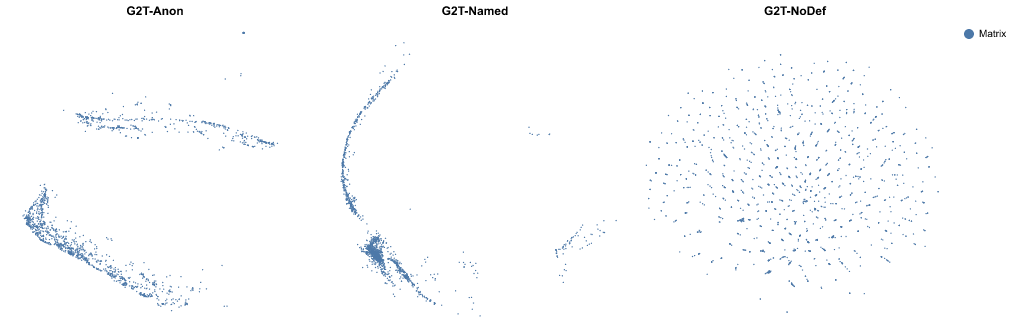

In [29]:
def make_chart():
    meta_df = g2t_meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in g2t_umap_dfs.items()}
    
    mask = g2t_meta_df["name"].str.startswith("mathcomp.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.match(r".*Matrix.*")
    meta_df = meta_df[mask].copy()
    umap_dfs = {k: df[mask].copy() for k, df in umap_dfs.items()}
    
    display(meta_df)
    color = {"x": meta_df["name"].str.extract(r".*(Matrix).*")[0]}
    return plot_umap3(umap_dfs, color=color, size=2, opacity=1, tooltip=meta_df[["name"]])
chart = make_chart()
chart.save("umap_g2t_matrix.png", scale_factor=4)
chart

In [67]:
#def process(df):
#    df = df.copy()
#    df = df[df["name"].str.startswith("mathcomp.")]
#    return df
#dfs = {k: process(df) for k, df in g2t_dfs.items()}
#chart1 = plot_umap3(dfs, color=color, opacity=0.05)
#
#def process2(df):
#    df = df.copy()
#    df[df["name"].str.match(r".*poly_X.Y.*")]
#    return df
#
#dfs = {k: process2(df) for k, df in dfs.items()}
#chart2 = plot_umap3(dfs, opacity=0.05, size=10)
#
#chart1 + chart2

In [30]:
from pathlib import Path
from pytact.data_reader import data_reader, TacticalConstant

In [31]:
def get_meta_data(dataset_path: Path):
    definitions = []
    with data_reader(dataset_path) as data:
        for datafile in data.values():
            for df in datafile.definitions():
                definitions.append({
                    "name": df.name, 
                    "type": type(df.kind).__name__,
                    "id": df.node.identity,
                })
    return pd.DataFrame(definitions)

In [32]:
test_meta_data_df = get_meta_data(TEST_DATASET_PATH)
test_meta_data_df

,name,type,id
0,Coq.Init.Specif.sig,Inductive,4883209569112333751
1,Coq.Init.Specif.exist,Inductive,-7930409544314449433
2,Coq.Init.Specif.sig_rect,ManualConstant,-7134545994354794196
3,Coq.Init.Specif.sig_sind,ManualConstant,695233438684831637
4,Coq.Init.Specif.sig_ind,ManualConstant,8512698767232647404
...,...,...,...
997,Coq.Init.Datatypes.identity_rec,ManualConstant,-8692179752832903310
998,Coq.Init.Datatypes.ID,ManualConstant,-1820331384248008047
999,Coq.Init.Datatypes.id,ManualConstant,-5411292743541515507
1000,Coq.Init.Datatypes.IDProp,ManualConstant,-1465859955979442715


In [33]:
g2t_meta_data_df = get_meta_data(G2T_DATASET_PATH)
g2t_meta_data_df

,name,type,id
0,gaia.ordinals.sset16b.SmallOrdinals.card_15,ManualConstant,9125047028083281740
1,gaia.ordinals.sset16b.SmallOrdinals.card_8,ManualConstant,2753851669449023672
2,gaia.ordinals.sset16b.SmallOrdinals.card_13,ManualConstant,-5330880422693784394
3,gaia.ordinals.sset16b.SmallOrdinals.card_19,ManualConstant,4029306311558137637
4,gaia.ordinals.sset16b.SmallOrdinals.nat_to_B3,TacticalConstant,-7739670494929297570
...,...,...,...
519772,mathcomp.apery.conj.Private.and_bootstrap,TacticalConstant,-5487440858290148470
519773,mathcomp.apery.conj.Private.and_eat_one,TacticalConstant,4329341176818821354
519774,mathcomp.apery.annotated_recs_b.Sn4_lcomb_cf1,ManualConstant,8962117471938318835
519775,mathcomp.apery.annotated_recs_b.Sn4_lcomb,ManualConstant,-1436682176746500430


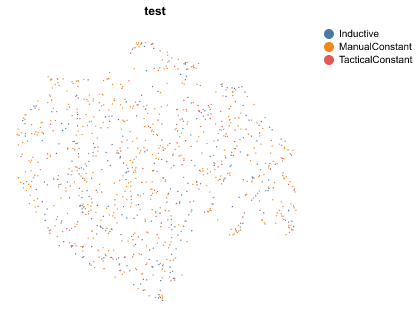

In [34]:
def make_chart():
    meta_df = test_meta_df.copy()
    umap_dfs = {"test": test_umap_df.copy()}

    meta_df = meta_df.set_index("id").join(test_meta_data_df.set_index("id")[["type"]]).reset_index()
    color = {"type": meta_df["type"]}
    return plot_umap3(umap_dfs, color=color, opacity=1)
chart = make_chart()
chart.save("umap_test_by_definition_type.png", scale_factor=4)
chart

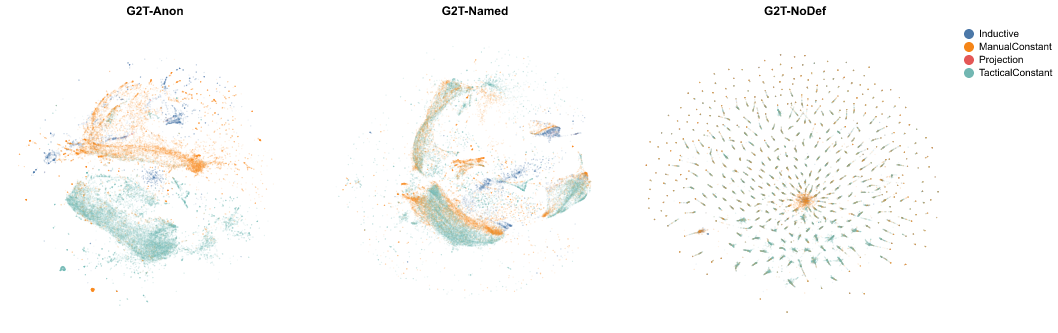

In [35]:
def make_chart():
    meta_df = g2t_meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in g2t_umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df = meta_df.reset_index()
    meta_df = meta_df.merge(g2t_meta_data_df.drop_duplicates()[["id", "type"]], on="id", how="left")
    meta_df = meta_df.set_index("index")

    color = {"type": meta_df["type"]}
    return plot_umap3(umap_dfs, color=color, opacity=.1, sample=0.1)
chart = make_chart()
chart.save("umap_g2t_by_definition_type.png", scale_factor=4)
chart

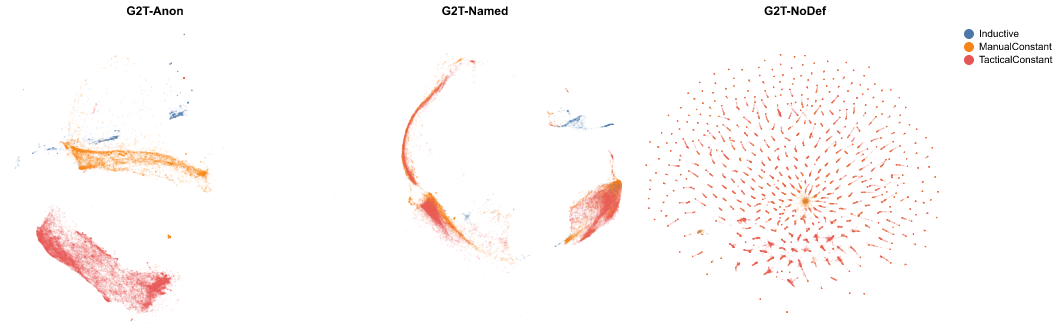

In [37]:
def make_chart():
    meta_df = g2t_meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in g2t_umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.startswith("mathcomp.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df = meta_df.reset_index()
    meta_df = meta_df.merge(g2t_meta_data_df.drop_duplicates()[["id", "type"]], on="id", how="left")
    meta_df = meta_df.set_index("index")

    color = {"type": meta_df["type"]}
    return plot_umap3(umap_dfs, color=color, opacity=.1)
chart = make_chart()
chart.save("umap_g2t_mathcomp_by_definition_type.png", scale_factor=4)
chart

In [38]:
from collections import defaultdict, Counter

def get_tactic_data(dataset_path: Path):
    id_to_tactic_cnts = defaultdict(Counter)
    with data_reader(dataset_path) as data:
        for datafile in data.values():
            for df in datafile.definitions():
                if isinstance(df.kind, TacticalConstant):
                    for proof_step in df.proof:
                        if proof_step.tactic is not None and len(proof_step.outcomes) > 0:
                            base_tactic = proof_step.tactic.base_text
                            for arg_node in proof_step.outcomes[0].tactic_arguments:
                                if arg_node is not None:
                                    id_to_tactic_cnts[arg_node.identity][base_tactic] += 1

    id_to_most_common_tactic = {i: max(cnt, key=cnt.get) for i, cnt in id_to_tactic_cnts.items()}
    return id_to_most_common_tactic

In [39]:
test_tactic_data = get_tactic_data(TEST_DATASET_PATH)
len(test_tactic_data)

296

In [40]:
g2t_tactic_data = get_tactic_data(G2T_DATASET_PATH)
len(g2t_tactic_data)

681333

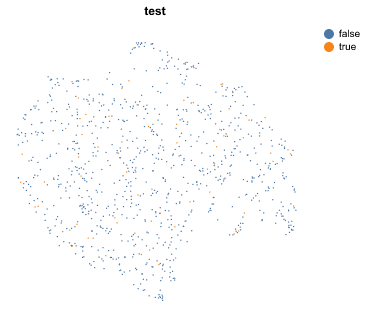

In [41]:
def make_chart(umap_dfs, meta_df, tactic_data):
    meta_df = meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df["base_tactic"] = meta_df["id"].map(tactic_data)

    color = {"tactic_arg": meta_df["base_tactic"].notna()}
    
    return plot_umap3(umap_dfs, color=color, opacity=1)
chart = make_chart({"test": test_umap_df}, test_meta_df, test_tactic_data)
chart.save("umap_test_by_tactic_arg.png", scale_factor=4)
chart

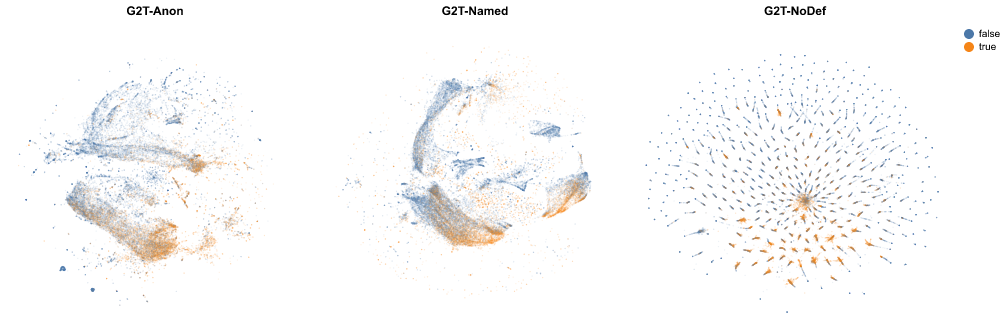

In [42]:
def make_chart(umap_dfs, meta_df, tactic_data):
    meta_df = meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df["base_tactic"] = meta_df["id"].map(tactic_data)

    color = {"tactic_arg": meta_df["base_tactic"].notna()}
    
    return plot_umap3(umap_dfs, color=color, opacity=.1, sample=0.1)
chart = make_chart(g2t_umap_dfs, g2t_meta_df, g2t_tactic_data)
chart.save("umap_g2t_by_tactic_arg.png", scale_factor=4)
chart

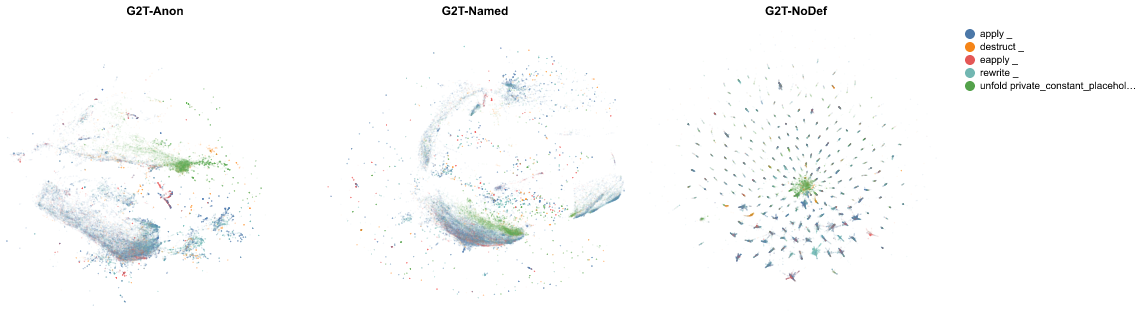

In [47]:
def make_chart(umap_dfs, meta_df, tactic_data):
    meta_df = meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df["base_tactic"] = meta_df["id"].map(tactic_data)

    top_tactics = meta_df["base_tactic"].value_counts()
    mask = meta_df["base_tactic"].isin(top_tactics.index[:5])
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    color = {"base_tactic": meta_df["base_tactic"]}
    
    return plot_umap3(umap_dfs, color=color, opacity=.05)
chart = make_chart(g2t_umap_dfs, g2t_meta_df, g2t_tactic_data)
chart.save("umap_g2t_by_top_tactics.png", scale_factor=4)
chart

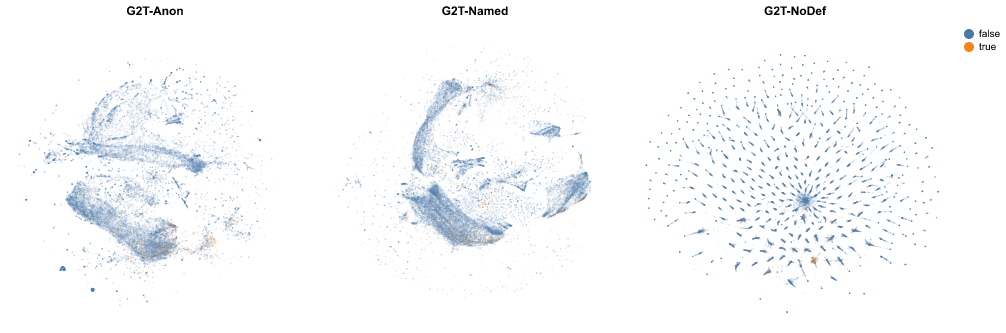

In [52]:
import numpy as np

def make_chart(umap_dfs, meta_df, tactic_data):
    meta_df = meta_df.copy()
    umap_dfs = {k: df.copy() for k, df in umap_dfs.items()}

    mask = meta_df["name"].str.contains(r"\.")
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    mask = ~meta_df["id"].duplicated()
    meta_df = meta_df[mask]
    umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    meta_df["base_tactic"] = meta_df["id"].map(tactic_data)

    #top_tactics = meta_df["base_tactic"].value_counts()
    #mask = meta_df["base_tactic"].isin(top_tactics.index[:5])
    #meta_df = meta_df[mask]
    #umap_dfs = {k: df[mask] for k, df in umap_dfs.items()}

    color = {"rewrite_argument": meta_df["base_tactic"] == "rewrite _"}
    
    return plot_umap3(umap_dfs, color=color, opacity=.1, sample=0.1)
chart = make_chart(g2t_umap_dfs, g2t_meta_df, g2t_tactic_data)
chart.save("umap_g2t_by_if_rewrite_arg.png", scale_factor=4)
chart